# This IPython notebook is a document for deriving monthly proportion of precipitation for different trajectory cluster during GDAS-covered period plus generating trajectory frequency plot
    by Xia and Butorovic for JGR-Atmospheres manuscript

Activate packages

In [1]:
import pysplit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Wrap trajectories into trajgroups and it takes several minutes to run

In [2]:
trajgroup_500 = pysplit.make_trajectorygroup(r'C:/trajectories/PA_GDAS/*PA*0500*')
print("number of 500-m trajectories:",trajgroup_500.trajcount)

trajgroup_1000 = pysplit.make_trajectorygroup(r'C:/trajectories/PA_GDAS/*PA*1000*')
print("number of 1000-m trajectories:",trajgroup_1000.trajcount)

trajgroup_1500 = pysplit.make_trajectorygroup(r'C:/trajectories/PA_GDAS/*PA*1500*')
print("number of 1500-m trajectories:",trajgroup_1500.trajcount)

trajgroup_2000 = pysplit.make_trajectorygroup(r'C:/trajectories/PA_GDAS/*PA*2000*')
print("number of 2000-m trajectories:",trajgroup_2000.trajcount)

number of 500-m trajectories: 7436
number of 1000-m trajectories: 7436
number of 1500-m trajectories: 7436
number of 2000-m trajectories: 7436


Define a function for preparing for trajectory analysis
* Read trajectory files, rainfall rate data at 0 hr, and relative humidity data at 0 hr, and put them into lists
* Four different hours (UTM 03h, 09h, 15h, and 21h) of the day are seperated as sublists

In [3]:
def prepare_traj(trajgroup):
    trajectory_list = [[],[],[],[]]
    rainfallrate_list = [[],[],[],[]]
    RH_list = [[],[],[],[]]
    for i in range(0,4):
        for traj in trajgroup[i::4]:
            trajectory_list[i].append(traj)
            rainfallrate_list[i].append("%.1f"%traj.data.Rainfall[0])
            RH_list[i].append("%.1f"%traj.data.Relative_Humidity[0])
    return trajectory_list,rainfallrate_list,RH_list

trajgroup_500_by_hour,rainfallrate_500_by_hour,RH_500_by_hour = prepare_traj(trajgroup_500)
trajgroup_1000_by_hour,rainfallrate_1000_by_hour,RH_1000_by_hour = prepare_traj(trajgroup_1000)
trajgroup_1500_by_hour,rainfallrate_1500_by_hour,RH_1500_by_hour = prepare_traj(trajgroup_1500)
trajgroup_2000_by_hour,rainfallrate_2000_by_hour,RH_2000_by_hour = prepare_traj(trajgroup_2000)

Define a function for selecting one trajectory on each day based on rainfall rate and relative humidity data at h = 0
* This function also include the procedure to mannually replace the "bad trajectory" by the other one
* "Bad trajectory" has an incomplete trajectory file (not backward modeled for 120 hours with file size less than 22 KB)

In [4]:
def select_traj(trajgroup,rainfallrate,RH,badtraj = [[]]):
    trajectory_list = []
    for i in range(0,len(trajgroup[0])):
        if i in badtraj[0]:
            trajectory_list.append(trajgroup[badtraj[1]][i])
            continue
        # the step above is for replacing the "bad trajectory"
        # the steps below are for looking for the "most likely preciptation-producing" trajectory
        if rainfallrate[0][i] > max(rainfallrate[1][i],rainfallrate[2][i],rainfallrate[3][i]):
            trajectory_list.append(trajgroup[0][i])
            continue
        elif rainfallrate[1][i] > max(rainfallrate[0][i],rainfallrate[2][i],rainfallrate[3][i]):
            trajectory_list.append(trajgroup[1][i])
            continue
        elif rainfallrate[2][i] > max(rainfallrate[0][i],rainfallrate[1][i],rainfallrate[3][i]):
            trajectory_list.append(trajgroup[2][i])
            continue
        elif rainfallrate[3][i] > max(rainfallrate[0][i],rainfallrate[1][i],rainfallrate[2][i]):
            trajectory_list.append(trajgroup[3][i])
            continue
        else:
            if rainfallrate[0][i] == rainfallrate[1][i] == rainfallrate[2][i] == rainfallrate[3][i] == '0.0'\
            and RH[0][i] >= max(RH[1][i],RH[2][i],RH[3][i]):
                trajectory_list.append(trajgroup[0][i])
                continue
            else:
                if rainfallrate[0][i] == rainfallrate[1][i] and rainfallrate[0][i] > max(rainfallrate[2][i],rainfallrate[3][i]):
                    if RH[0][i] >= RH[1][i]:
                        trajectory_list.append(trajgroup[0][i])
                        continue
                elif rainfallrate[0][i] == rainfallrate[2][i] and rainfallrate[0][i] > max(rainfallrate[1][i],rainfallrate[3][i]):
                    if RH[0][i] >= RH[2][i]:
                        trajectory_list.append(trajgroup[0][i])
                        continue
                elif rainfallrate[0][i] == rainfallrate[3][i] and rainfallrate[0][i] > max(rainfallrate[1][i],rainfallrate[2][i]):
                    if RH[0][i] >= RH[3][i]:
                        trajectory_list.append(trajgroup[0][i])
                        continue
                elif rainfallrate[0][i] == rainfallrate[1][i] == rainfallrate[2][i] != '0.0':
                    if RH[0][i] >= max (RH[1][i],RH[2][i]):
                        trajectory_list.append(trajgroup[0][i])
                        continue
                elif rainfallrate[0][i] == rainfallrate[1][i] == rainfallrate[3][i] != '0.0':
                    if RH[0][i] >= max (RH[1][i],RH[3][i]):
                        trajectory_list.append(trajgroup[0][i])
                        continue
                elif rainfallrate[0][i] == rainfallrate[2][i] == rainfallrate[3][i] != '0.0':
                    if RH[0][i] >= max (RH[2][i],RH[3][i]):
                        trajectory_list.append(trajgroup[0][i])
                        continue
            if rainfallrate[0][i] == rainfallrate[1][i] == rainfallrate[2][i] == rainfallrate[3][i] == '0.0'\
            and RH[1][i] >= max(RH[0][i],RH[2][i],RH[3][i]):
                trajectory_list.append(trajgroup[1][i])
                continue
            else:
                if rainfallrate[1][i] == rainfallrate[0][i] and rainfallrate[1][i] > max(rainfallrate[2][i],rainfallrate[3][i]):
                    if RH[1][i] >= RH[0][i]:
                        trajectory_list.append(trajgroup[1][i])
                        continue
                elif rainfallrate[1][i] == rainfallrate[2][i] and rainfallrate[1][i] > max(rainfallrate[0][i],rainfallrate[3][i]):
                    if RH[1][i] >= RH[2][i]:
                        trajectory_list.append(trajgroup[1][i])
                        continue
                elif rainfallrate[1][i] == rainfallrate[3][i] and rainfallrate[1][i] > max(rainfallrate[0][i],rainfallrate[2][i]):
                    if RH[1][i] >= RH[3][i]:
                        trajectory_list.append(trajgroup[1][i])
                        continue
                elif rainfallrate[1][i] == rainfallrate[0][i] == rainfallrate[2][i] != '0.0':
                    if RH[1][i] >= max (RH[0][i],RH[2][i]):
                        trajectory_list.append(trajgroup[1][i])
                        continue
                elif rainfallrate[1][i] == rainfallrate[0][i] == rainfallrate[3][i] != '0.0':
                    if RH[1][i] >= max (RH[0][i],RH[3][i]):
                        trajectory_list.append(trajgroup[1][i])
                        continue
                elif rainfallrate[1][i] == rainfallrate[2][i] == rainfallrate[3][i] != '0.0':
                    if RH[1][i] >= max (RH[2][i],RH[3][i]):
                        trajectory_list.append(trajgroup[1][i])
                        continue
            if rainfallrate[0][i] == rainfallrate[1][i] == rainfallrate[2][i]==rainfallrate[3][i] == '0.0'\
            and RH[2][i] >= max(RH[0][i],RH[1][i],RH[3][i]):
                trajectory_list.append(trajgroup[2][i])
                continue
            else:
                if rainfallrate[2][i] == rainfallrate[0][i] and rainfallrate[2][i] > max(rainfallrate[1][i],rainfallrate[3][i]):
                    if RH[2][i] >= RH[0][i]:
                        trajectory_list.append(trajgroup[2][i])
                        continue
                elif rainfallrate[2][i] == rainfallrate[1][i] and rainfallrate[2][i] > max(rainfallrate[0][i],rainfallrate[3][i]):
                    if RH[2][i] >= RH[1][i]:
                        trajectory_list.append(trajgroup[2][i])
                        continue
                elif rainfallrate[2][i] == rainfallrate[3][i] and rainfallrate[2][i] > max(rainfallrate[0][i],rainfallrate[1][i]):
                    if RH[2][i] >= RH[3][i]:
                        trajectory_list.append(trajgroup[2][i])
                        continue
                elif rainfallrate[2][i] == rainfallrate[0][i] == rainfallrate[1][i] != '0.0':
                    if RH[2][i] >= max (RH[0][i],RH[1][i]):
                        trajectory_list.append(trajgroup[2][i])
                        continue
                elif rainfallrate[2][i] == rainfallrate[0][i] == rainfallrate[3][i] != '0.0':
                    if RH[2][i] >= max (RH[0][i],RH[3][i]):
                        trajectory_list.append(trajgroup[2][i])
                        continue
                elif rainfallrate[2][i] == rainfallrate[1][i] == rainfallrate[3][i] != '0.0':
                    if RH[2][i] >= max (RH[1][i],RH[3][i]):
                        trajectory_list.append(trajgroup[2][i])
                        continue
            if rainfallrate[0][i] == rainfallrate[1][i] == rainfallrate[2][i] == rainfallrate[3][i] == '0.0'\
            and RH[3][i] >= max(RH[0][i],RH[1][i],RH[2][i]):
                trajectory_list.append(trajgroup[3][i])
                continue
            else:
                if rainfallrate[3][i] == rainfallrate[0][i] and rainfallrate[3][i] > max(rainfallrate[1][i],rainfallrate[2][i]):
                    if RH[3][i] >= RH[0][i]:
                        trajectory_list.append(trajgroup[3][i])
                        continue
                elif rainfallrate[3][i] == rainfallrate[1][i] and rainfallrate[3][i] > max(rainfallrate[0][i],rainfallrate[2][i]):
                    if RH[3][i] >= RH[1][i]:
                        trajectory_list.append(trajgroup[3][i])
                        continue
                elif rainfallrate[3][i] == rainfallrate[2][i] and rainfallrate[3][i] > max(rainfallrate[0][i],rainfallrate[1][i]):
                    if RH[3][i] >= RH[2][i]:
                        trajectory_list.append(trajgroup[3][i])
                        continue
                elif rainfallrate[3][i] == rainfallrate[0][i] == rainfallrate[1][i] != '0.0':
                    if RH[3][i] >= max (RH[0][i],RH[1][i]):
                        trajectory_list.append(trajgroup[3][i])
                        continue
                elif rainfallrate[3][i] == rainfallrate[0][i] == rainfallrate[2][i] != '0.0':
                    if RH[3][i] >= max (RH[0][i],RH[2][i]):
                        trajectory_list.append(trajgroup[3][i])
                        continue
                elif rainfallrate[3][i] == rainfallrate[1][i] == rainfallrate[2][i] != '0.0':
                    if RH[3][i] >= max (RH[1][i],RH[2][i]):
                        trajectory_list.append(trajgroup[3][i])
                        continue
    return pysplit.TrajectoryGroup(trajectory_list)

selected_trajgroup_500 = select_traj(trajgroup_500_by_hour,rainfallrate_500_by_hour,RH_500_by_hour)
print("the total number of selected trajectories (500-m):",selected_trajgroup_500.trajcount)
selected_trajgroup_1000 = select_traj(trajgroup_1000_by_hour,rainfallrate_1000_by_hour,RH_1000_by_hour,[[1819],(0)])
# 1000m trajgroup would have included the one of 09/29/2015 21:00, which was a bad trajectory.
# It was replaced by 09/29/2015 03:00 maually. This step is trivial.
print("the total number of selected trajectories (1000-m):",selected_trajgroup_1000.trajcount)
selected_trajgroup_1500 = select_traj(trajgroup_1500_by_hour,rainfallrate_1500_by_hour,RH_1500_by_hour)
print("the total number of selected trajectories (1500-m):",selected_trajgroup_1500.trajcount)
selected_trajgroup_2000 = select_traj(trajgroup_2000_by_hour,rainfallrate_2000_by_hour,RH_2000_by_hour)
print("the total number of selected trajectories (2000-m):",selected_trajgroup_2000.trajcount)

the total number of selected trajectories (500-m): 1859
the total number of selected trajectories (1000-m): 1859
the total number of selected trajectories (1500-m): 1859
the total number of selected trajectories (2000-m): 1859


Define a function to cluster trajectory into distal clusters and proximal clusters
* If trajectory cluster is identified, then trajectory is put into list (e.g., cluster_dE) of that cluster.
* The identifier of trajectory cluster is also put into a list (e.g., cluster_list_distal) as a sequence for following analysis

In [5]:
def cluster_traj_distal(trajgroup):
    cluster_dE,cluster_dN,cluster_dW,cluster_dS = [],[],[],[]
    cluster_list_distal = []
    for traj in trajgroup:
        cluster = "default"
        t = 0
        for step in range(0,120):
            if traj.data.geometry.loc[t].y < traj.data.geometry.loc[t].x + 18:
                if traj.data.geometry.loc[t].y > -2.5 * traj.data.geometry.loc[t].x - 223.5:
                    if traj.data.geometry.loc[t].y > -0.5 * traj.data.geometry.loc[t].x -87.5:
                        cluster = "dE"
                        cluster_dE.append(traj)
            if traj.data.geometry.loc[t].y > -48:
                if traj.data.geometry.loc[t].y > -2.3333 * traj.data.geometry.loc[t].x - 223:
                    if traj.data.geometry.loc[t].y > traj.data.geometry.loc[t].x + 18:
                        cluster = "dN"
                        cluster_dN.append(traj)
            if traj.data.geometry.loc[t].y < -2.3333 * traj.data.geometry.loc[t].x - 223:
                cluster = "dW"
                cluster_dW.append(traj)
            if traj.data.geometry.loc[t].y < -55:
                if traj.data.geometry.loc[t].y > -2.3333 * traj.data.geometry.loc[t].x - 223:
                    if traj.data.geometry.loc[t].y < -0.5 * traj.data.geometry.loc[t].x - 87.5:
                        cluster = "dS"
                        cluster_dS.append(traj)
            if cluster != "default":
                break
            t = t - 1
        if cluster == "default":
            print("no boundary crossed on yr mn dy hr:",traj.data.DateTime.dt.year[0],traj.data.DateTime.dt.month[0],\
                  traj.data.DateTime.dt.day[0],traj.data.DateTime.dt.hour[0])
            # Some of 500m trajectories were not clustered to any because they do not go across any boundaries
            # These trajectories were manually clustered into dN based on the plot of trajectory path
            cluster = "dN"
            cluster_dN.append(traj)
        cluster_list_distal.append(cluster)
    return cluster_list_distal,cluster_dE,cluster_dN,cluster_dW,cluster_dS

def cluster_traj_proximal(trajgroup):
    cluster_pE,cluster_pW = [],[]
    cluster_list_proximal = []
    for traj in trajgroup:
        cluster = 0
        if traj.data.geometry.loc[-6].x >= -70.9171:
            cluster = "pE"
            cluster_pE.append(traj)
        else:
            cluster = "pW"
            cluster_pW.append(traj)
        cluster_list_proximal.append(cluster)
    return cluster_list_proximal,cluster_pE,cluster_pW

cluster_list_distal_500,cluster_dE_500,cluster_dN_500,cluster_dW_500,cluster_dS_500 = cluster_traj_distal(selected_trajgroup_500)
cluster_list_distal_1000,cluster_dE_1000,cluster_dN_1000,cluster_dW_1000,cluster_dS_1000 = cluster_traj_distal(selected_trajgroup_1000)
cluster_list_distal_1500,cluster_dE_1500,cluster_dN_1500,cluster_dW_1500,cluster_dS_1500 = cluster_traj_distal(selected_trajgroup_1500)
cluster_list_distal_2000,cluster_dE_2000,cluster_dN_2000,cluster_dW_2000,cluster_dS_2000 = cluster_traj_distal(selected_trajgroup_2000)

cluster_list_proximal_500,cluster_pE_500,cluster_pW_500 = cluster_traj_proximal(selected_trajgroup_500)
cluster_list_proximal_1000,cluster_pE_1000,cluster_pW_1000 = cluster_traj_proximal(selected_trajgroup_1000)
cluster_list_proximal_1500,cluster_pE_1500,cluster_pW_1500 = cluster_traj_proximal(selected_trajgroup_1500)
cluster_list_proximal_2000,cluster_pE_2000,cluster_pW_2000 = cluster_traj_proximal(selected_trajgroup_2000)

no boundary crossed on yr mn dy hr: 2012 3 1 15
no boundary crossed on yr mn dy hr: 2013 9 4 15


Define a function to calculate monthly proportion of each cluster's precipitation

In [6]:
df_precipitation = pd.read_csv("Punta Arenas precipitation.csv")
df_precip = df_precipitation[df_precipitation["precipitation"] != 0.0].reset_index(drop = True)

def calculate_monthly(distal,proximal,trajgroup):
    year,month,day = [],[],[]
    for traj in trajgroup:
        year.append(traj.data.DateTime.dt.year[0])
        month.append(traj.data.DateTime.dt.month[0])
        day.append(traj.data.DateTime.dt.day[0])
    df = pd.DataFrame(list(zip(year,month,day)),columns = ["year","month","day"])
    df = pd.merge(df, df_precip)
    year,month = [],[]
    dE_ratio,dN_ratio,dW_ratio,dS_ratio,pE_ratio,pW_ratio = [],[],[],[],[],[]
    for yr in range(2005,2016):
        for mn in range(1,13):
            dE = dN = dW = dS = pE = pW = monthly = 0
            for i in range(len(df)):
                if df["year"][i] == yr and df["month"][i] == mn:
                    if distal[i] == "dE":
                        dE = dE + df["precipitation"][i]
                    if distal[i] == "dN":
                        dN = dN + df["precipitation"][i]
                    if distal[i] == "dW":
                        dW = dW + df["precipitation"][i]
                    if distal[i] == "dS":
                        dS = dS + df["precipitation"][i]
                    if proximal[i] == "pE":
                        pE = pE + df["precipitation"][i]
                    if proximal[i] == "pW":
                        pW = pW + df["precipitation"][i]
                    monthly = monthly + df["precipitation"][i]
            year.append(yr)
            month.append(mn)
            dE_ratio.append(dE/monthly*100)
            dN_ratio.append(dN/monthly*100)
            dW_ratio.append(dW/monthly*100)
            dS_ratio.append(dS/monthly*100)
            pE_ratio.append(pE/monthly*100)
            pW_ratio.append(pW/monthly*100)
    return pd.DataFrame(list(zip(year,month,dE_ratio,dN_ratio,dW_ratio,dS_ratio,pE_ratio,pW_ratio)),
                        columns = ["year","month","dE%","dN%","dW%","dS%","pE%","pW%"])
df_results_500 = calculate_monthly(cluster_list_distal_500,cluster_list_proximal_500,selected_trajgroup_500)
df_results_1000 = calculate_monthly(cluster_list_distal_1000,cluster_list_proximal_1000,selected_trajgroup_1000)
df_results_1500 = calculate_monthly(cluster_list_distal_1500,cluster_list_proximal_1500,selected_trajgroup_1500)
df_results_2000 = calculate_monthly(cluster_list_distal_2000,cluster_list_proximal_2000,selected_trajgroup_2000)

Plot data as time series

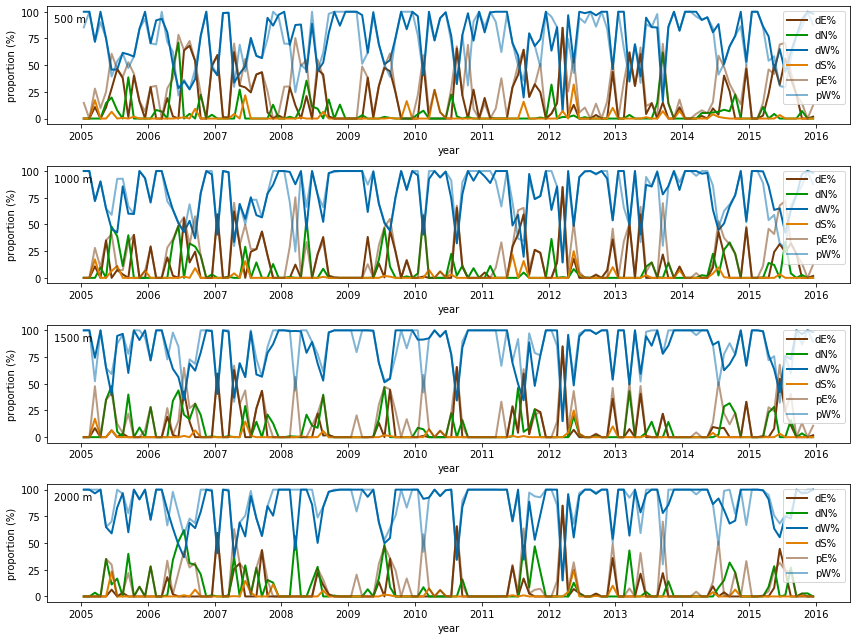

In [7]:
plt.figure(figsize=(12,9))
def plot_time_series(data,sub,m):
    plt.subplot(4,1,sub)
    plt.plot(data['year']+(data['month']*2-1)/24,data['dE%'],linewidth=2,color='#753909')
    plt.plot(data['year']+(data['month']*2-1)/24,data['dN%'],linewidth=2,color='#009300')
    plt.plot(data['year']+(data['month']*2-1)/24,data['dW%'],linewidth=2,color='#006BAC')
    plt.plot(data['year']+(data['month']*2-1)/24,data['dS%'],linewidth=2,color='#E18000')
    plt.plot(data['year']+(data['month']*2-1)/24,data['pE%'],linewidth=2,color='#753909',alpha=0.5)
    plt.plot(data['year']+(data['month']*2-1)/24,data['pW%'],linewidth=2,color='#006BAC',alpha=0.5)
    plt.xticks(range(2005, 2017, 1))
    plt.xlabel('year')
    plt.ylabel('proportion (%)')
    plt.text(2004.6,90,m)
    legend=plt.legend(("dE%","dN%","dW%","dS%","pE%","pW%"),loc=1)
plot_time_series(df_results_500,1,"500 m")
plot_time_series(df_results_1000,2,"1000 m")
plot_time_series(df_results_1500,3,"1500 m")
plot_time_series(df_results_2000,4,"2000 m")
plt.tight_layout()

Plot GNIP data versus GHCN temperature
* GNIP data are filtered and only d18O data ranging from -17 to -3 permil were used.
* The regression line was used to calculate d18O residual.

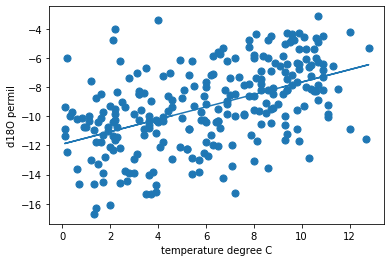

In [8]:
df_GNIP = pd.read_csv("GNIP data.csv")
plt.scatter(df_GNIP['GHCN_temperature'],df_GNIP['d18O'],s=50)
plt.xlabel('temperature degree C')
plt.ylabel('d18O permil')
m, b = np.polyfit(df_GNIP['GHCN_temperature'],df_GNIP['d18O'], 1)
plt.plot(df_GNIP['GHCN_temperature'],m*df_GNIP['GHCN_temperature']+b)

Calculate d18O residual

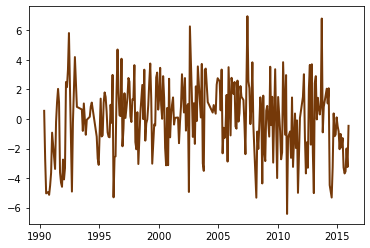

In [9]:
d18O_residual = []
for i in range(0,len(df_GNIP.d18O)):
    d18O_residual.append(df_GNIP['d18O'][i]-(m*df_GNIP['GHCN_temperature'][i]+b))
df_GNIP['d18O residual'] = d18O_residual
plt.plot(df_GNIP['year']+(df_GNIP['month']*2-1)/24,df_GNIP['d18O residual'],linewidth=2,color='#753909')

Calculate trajectory frequency grid using 500m-trajgroup as an example

In [10]:
array = []
for traj in selected_trajgroup_500:
    t=0
    for step in range(0,121):
        row = (int((round(traj.data.geometry.loc[t].y)))+90)*361+int((round(traj.data.geometry.loc[t].x)))+180
        array.append(row)
        t=t-1
# read every coordinate data along each trajectory into "array" list

count = []
for i in range(0,65341):
    count.append(array.count(i))
# count each grid

freq = []
for i in count:
    freq.append(i/sum(count)*100*121)
# calculate grid frequency

x = np.arange(-180,181,1)
y = np.arange(-90,91,1)
X, Y = np.meshgrid(x, y)
Z = np.reshape(freq, (181,361))
# get ready for frequency plot

Make the trajectory frequency plot

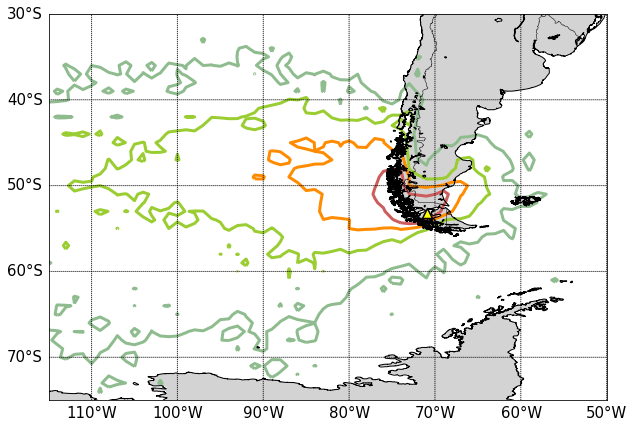

In [12]:
mapcorners = [-115, -75, -50, -30]
standard_pm = None
bmap_params = pysplit.MapDesign(mapcorners,standard_pm,mapcolor=None,latlon_spacing=(10,10),
                                latlon_labelspacing=(10,10),
                                lon_labels=['bottom'], latlon_fs=15,
                                drawoutlines=True,resolution='h',area_threshold=100,
                                zmapbound=100)
bmap = bmap_params.make_basemap()
bmap.drawlsmask(land_color = "#d3d3d3", ocean_color="white")
bmap.scatter(-70.9171,-53.1638,marker='^',c='yellow',zorder=20, s=100,edgecolors='black',linewidths=1.5)
plt.contour(X,Y,Z,levels=(2,5,10,20),colors=('darkseagreen','yellowgreen','darkorange','indianred'),linewidths=3)